# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1732      0 --:--:-- --:--:-- --:--:--  1739
100 1546k  100 1546k    0     0  3483k      0 --:--:-- --:--:-- --:--:-- 3483k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1486      0 --:--:-- --:--:-- --:--:--  1480
100  385k  100  385k    0     0   804k      0 --:--:-- --:--:-- --:--:--  804k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1099      0 --:--:-- --:--:-- --:--:--  1099
100  230k  100  230k    0     0   405k      0 --:--:-- --:--:-- --:--:-- 7445k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
!pip install seaborn --upgrade

In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

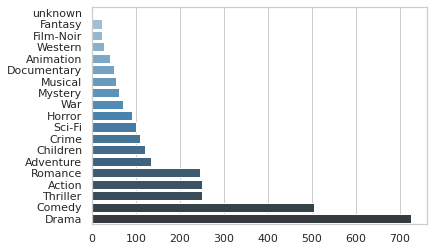

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** SVD, o singular value decomposition, es una descomposición matricial de una matriz R de tipo R = $M \Sigma U^T$, en el cual M y U son ortogonales y $\Sigma$ es la matriz diagonal de valores singulares. Con estas matrices calculadas, para predecir el rating que un usuario le daría a un item, entonces podemos multiplicar los vectores asociados a estos elementos en las matrices M y U. 

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values][["title","release_date", "IMDb_URL"]]

,title,release_date,IMDb_URL
movieid,,,
13,Mighty Aphrodite (1995),30-Oct-1995,http://us.imdb.com/M/title-exact?Mighty%20Aphr...
19,Antonia's Line (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Antonia%20(1995)
50,Star Wars (1977),01-Jan-1977,http://us.imdb.com/M/title-exact?Star%20Wars%2...
100,Fargo (1996),14-Feb-1997,http://us.imdb.com/M/title-exact?Fargo%20(1996)
127,"Godfather, The (1972)",01-Jan-1972,"http://us.imdb.com/M/title-exact?Godfather,%20..."
237,Jerry Maguire (1996),13-Dec-1996,http://us.imdb.com/M/title-exact?Jerry%20Magui...
251,Shall We Dance? (1996),11-Jul-1997,http://us.imdb.com/M/title-exact?Shall%20we%20...
255,My Best Friend's Wedding (1997),20-Jun-1997,http://us.imdb.com/M/title-exact?My+Best+Frien...
257,Men in Black (1997),04-Jul-1997,http://us.imdb.com/M/title-exact?Men+in+Black+...


In [14]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [15]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7206474264476331
RMSE: 0.9142927656291666


In [16]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11174573000932395
NDCG@20: 0.05995203402373199


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 1512, 1398, 169, 1367, 318, 64, 1137, 408, 483, 1642, 1639, 963, 12, 114, 1536, 134, 480, 189, 1558]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1398,Anna (1996),13-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Anna%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1137,Beautiful Thing (1996),09-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Beautiful%20T...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió. 
Para ver como afecta los distintos valores de los parámetros del entrenamiento, vamos a dejar todos los parametros constantes, menos uno (el que estamos estudiando).

Primero, vamos a ver como afecta el número de factores latentes. Al correr el siguiente código, nos damos cuenta que al aumentar la cantidad de factores latentes entonces el modelo se demoró más en entrenarse. Desde el factor latente inicial, podemos ver que el error aumenta si es que disminuimos la cantidad de factores latentes, y disminuye si aumentamos la cantidad de factores latentes. Esto puede verse como tener más informacion (más factores latentes) para expresar la información, y por lo tanto, se entiende este comportamiento). Sin embargo, este error no disminuye tanto, y se puede ver en las recomendaciones que estas no varían mucho. Por ejemplo, con los factores latentes usados, estos 3 modelos comparten un poco más de la mitad de las recomendaciones. 

In [21]:
user_id = 2
top_n = 10
factores_latentes = [70, 100, 600]


for f in factores_latentes:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))

  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.720318840565555
RMSE: 0.9149262009048256
Recommendation for user 2: [1512, 1449, 1500, 12, 408, 169, 64, 1450, 134, 174]
MAE: 0.7198261140212939
RMSE: 0.9138938007266001
Recommendation for user 2: [1512, 1449, 1642, 169, 189, 1536, 408, 1467, 12, 483]
MAE: 0.7199437303926951
RMSE: 0.9128049993116037
Recommendation for user 2: [1449, 1512, 169, 408, 64, 480, 318, 483, 12, 134]


En el caso de cambiar el valor de iteraciones, se puede ver que el error aumenta con la cantidad de iteraciones. Esto podría ser debido a un over-fitting, lo que significa que el modelo se está "aprendiendo" la data de entrenamiento y no lo generaliza para el momento de predecir con un usuario y un item completamente nuevo. En el caso de las recommendaciones, estas no cambian mucho, excepto por el orden de algunos items. 

In [20]:
user_id = 2
top_n = 10
iteraciones = [50, 100, 300]


for i in iteraciones:
  svd.train(factors=100, maxiter=i, lr=0.01, lamb=0.1)
  predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))



  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.7202190384430145
RMSE: 0.9136620619332905
Recommendation for user 2: [1449, 1512, 408, 169, 1367, 114, 483, 480, 64, 613]
MAE: 0.7203045736339435
RMSE: 0.9137234851528688
Recommendation for user 2: [1449, 1512, 169, 408, 1467, 318, 513, 963, 12, 64]
MAE: 0.7219743035777766
RMSE: 0.9159098317575893
Recommendation for user 2: [1512, 1449, 1398, 1064, 1467, 963, 169, 1463, 408, 1642]


Al cambiar el learning rate, aumentarlo o disminuirlo, esto aumentaría el error. Si el learning rate se disminuye, puede pasar que no sea suficiente para encontrar converger en el modelo óptimo, y por lo tanto, se tendría que aumentar. Si el learning rate es muy alto, entonces puede pasar que al entrenar el modelo se esté pasando de la solución optima. Al mirar las recomendaciones que nos dan, estas son muy distintas, y entonces se necesitaría un mejor análisis de este parametro para ver su óptimo valor (ya que su valor default es relativamente chico, tal vez los valores que puse fueron muy drásticos). 

In [22]:
user_id = 2
top_n = 10
learning_rates = [0.005, 0.01, 0.02]


for l in learning_rates:
  svd.train(factors=100, maxiter=100, lr=l, lamb=0.1)
  predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))



  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.7185077006727978
RMSE: 0.9120925266356067
Recommendation for user 2: [1449, 1512, 483, 603, 169, 12, 408, 134, 318, 1467]
MAE: 0.7204494636852027
RMSE: 0.9142529424858745
Recommendation for user 2: [169, 408, 1449, 1367, 1398, 1512, 64, 1467, 114, 1645]
MAE: 0.7245300379484596
RMSE: 0.9183978666950469
Recommendation for user 2: [1536, 1398, 1512, 1449, 169, 1558, 64, 408, 12, 963]


Al igual que el learning rate, el lambda (o el parametro de regularizaion) tambien aumenta el error si es que lo disminuimos o lo aumentamos. Por la misma razón, esto puede ser debido a que la variación debería ser mucho menos a lo que yo hice. A simple vista, las recomendaciones que se dan son bastantes similares, aparte del orden en que se dan algunas recomendaciones. 

In [23]:
user_id = 2
top_n = 10
lambdas = [0.5, 0.1, 0.2]


for l in lambdas:
  svd.train(factors=100, maxiter=100, lr=0.01, lamb=l)
  predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))



  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

MAE: 0.7748419064885422
RMSE: 0.9643936562649521
Recommendation for user 2: [1512, 1467, 1500, 814, 1536, 1449, 1189, 1450, 1064, 1293]
MAE: 0.7209613252353383
RMSE: 0.9144914501240516
Recommendation for user 2: [1467, 1512, 1449, 408, 169, 1367, 513, 64, 1558, 483]
MAE: 0.7425317260451596
RMSE: 0.9348785553183533
Recommendation for user 2: [1512, 1449, 1467, 1500, 1536, 1367, 1642, 408, 169, 1398]


**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [20]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7204058439976143, 0.7200559956121918, 0.720391203270627]
[0.9143904162164153, 0.9131474737526171, 0.9135860494070488]
Recommendation for user 2: [1449, 1512, 169, 1367, 408, 64, 1398, 1642, 1589, 480]


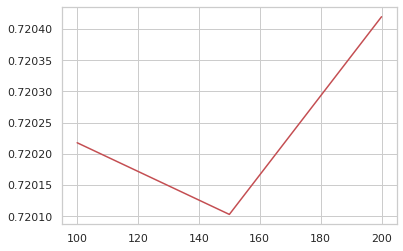

In [ ]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

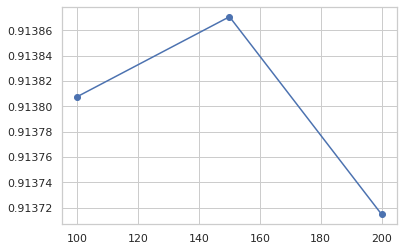

In [ ]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

Al probar distintos valores para la cantidad de iteraciones, se puede ver en los gráficos de errores que el valor maxiter=50 nos dá el error más bajo. 

In [54]:
iteraciones = [10, 25, 50, 100, 150]
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for i in iteraciones:
  svd.train(factors=100, maxiter=i, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7459719683322195, 0.7255250448224531, 0.7195690208166124, 0.7207268244239342, 0.7214533693929478]
[0.9438949333328714, 0.9199503710526125, 0.913596277472999, 0.9149619755097639, 0.9149554647510733]


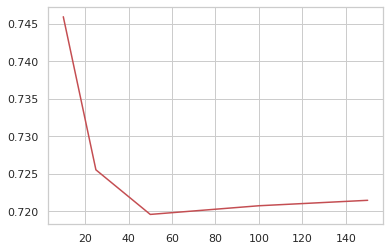

In [55]:
plt.plot(iteraciones, mae_values, 'r-')
plt.show()

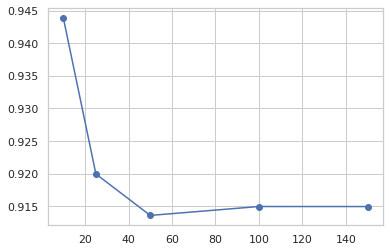

In [56]:
plt.plot(iteraciones, rmse_values, 'bo-')
plt.show()

En el caso de learning rates, fuí disminuyendo el valor para ver como se comportaban los errores. Para un valor de 0.008, de puede ver que MAE encuentra un valor mínimo. En el caso de RMSE, este tiene un comportamiento medio raro ya que aumenta o disminuye cada vez que cambiamos el valor. Esto puede ser porque RMSE se saca el cuadrado del error, y puede pasar que cuando se cambie el learning rate se inflen unos errores que no estaban presentes en los otros.

In [51]:
learning_rates = [0.003, 0.008, 0.01, 0.015]
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for l in learning_rates:
  svd.train(factors=100, maxiter=100, lr=l, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7203228472405393, 0.7202083086517168, 0.7206465478360673, 0.7228233992517742]
[0.9136041133162133, 0.9145130638674432, 0.9143710138540334, 0.9169919238651432]


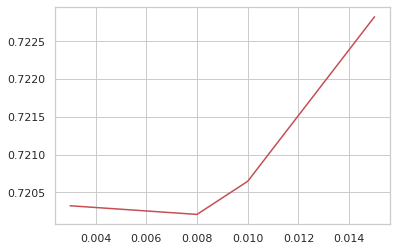

In [52]:
plt.plot(learning_rates, mae_values, 'r-')
plt.show()

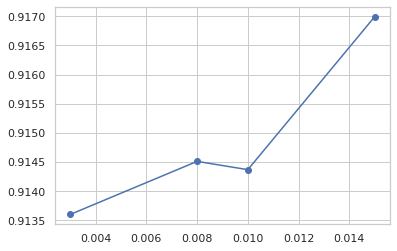

In [53]:
plt.plot(learning_rates, rmse_values, 'bo-')
plt.show()

Al probar con distintos valores para lambda, en los gráficos vemos que el error se hace mínimo cuando lambda=0.1, el cual es el valor por defecto. 

In [45]:
lambdas = [0.08, 0.1, 0.15, 0.2]
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for l in lambdas:
  svd.train(factors=100, maxiter=100, lr=0.01, lamb=l)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7230204513173311, 0.7208218336594194, 0.7283325382386995, 0.7426342606429961]
[0.9188290722187404, 0.9146498065543159, 0.920261168830956, 0.9349246106269076]


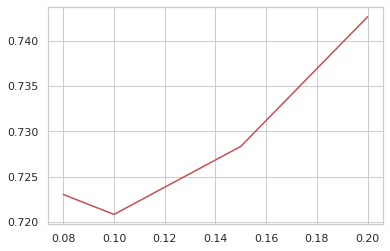

In [46]:
plt.plot(lambdas, mae_values, 'r-')
plt.show()

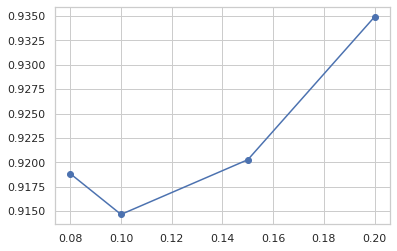

In [47]:
plt.plot(lambdas, rmse_values, 'bo-')
plt.show()